In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.ndimage import gaussian_filter
from functools import partial
import operator
from IPython.display import clear_output
from tqdm import tqdm
import networkx as nx
import timeit
import random
import copy
import community as community_louvain
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, BASE_COLORS
from itertools import product
import json
from imageio import imwrite

In [2]:
%autoreload 2
from utils import summary, visualise, string_to_color, visualise_at_interval, convertImage, initialize_data_loader

# Canvas reproduction

In [ ]:
visualise_at_interval(
    lambda rez, row, is_mod : row.pixel_color, 
    lambda l : list(tqdm((convertImage(x,string_to_color) for x in l), total=len(l))), 
    pd.Timedelta(minutes = 15), 
    [["#FFFFFF" for i in range(2000)] for i in range(1000)],
    "image",
) 

# Activity

In [ ]:
def get_transform(images, blur = 0):
    blurImages =[gaussian_filter(np.array(img), blur) for img in images]
    maximum = np.max(blurImages)
    custom_cmap = ScalarMappable(cmap='RdBu_r', norm=LogNorm(vmin=1, vmax=maximum + 1))
    return [custom_cmap.to_rgba(img, bytes= True) for img in blurImages]

In [ ]:

visualise_at_interval(
    lambda rez, row: rez + 1, 
    get_transform,
    pd.Timedelta(minutes = 15), 
    np.ones((1000,2000)),
    "activite",
    duration = pd.Timedelta(minutes = 30),
) 

In [ ]:

visualise_at_interval(
    lambda rez, row : rez + 1, 
    get_transform, 
    -1, 
    np.ones((1000,2000)),
    "activite_total",
) 

In [ ]:
blurs =[1,2,5,10,50,100]
visualise_at_interval(
    lambda rez, row  : rez + 1, 
    { str(blur) : partial(get_transform, blur = blur) for blur in blurs}, 
    pd.Timedelta(minutes = 15), 
    np.ones((1000,1000)),
    lambda blur : f"activite_blur_{blur}",
    duration = pd.Timedelta(minutes = 30),
) 


visualise_at_interval(
    lambda rez, row : rez + int(not row.is_mod), 
    { str(blur) : partial(get_transform, blur = blur) for blur in blurs}, 
    pd.Timedelta(minutes = 15), 
    np.ones((1000,1000)),
    lambda blur : f"activite_blur_no_moderator_{blur}",
    duration = pd.Timedelta(minutes = 30),
) 


# Variété d'utilisateur

In [ ]:
def compose(f, g):
    return lambda *args, **kwargs : f(g(*args, **kwargs))

def add_user(user, users):
    users.add(user)
    return users

def from_users_sets_by_points_to_len_by_points(images):
    return [[[len(user_set)+1 for user_set in row] for row in image] for image in images]

In [ ]:
blurs =[1,5,10]
visualise_at_interval(
    lambda users, _, user, is_mod  : users if is_mod else add_user(user, users), 
    { str(blur) : compose(partial(get_transform, blur = blur),
                          from_users_sets_by_points_to_len_by_points) for blur in blurs}, 
    pd.Timedelta(minutes = 5), 
    [[set() for i in range(1000)] for j in range(1000)],
    lambda blur : f"users_variety_blur{blur}",
    duration = pd.Timedelta(minutes = 15),
)

# Détection de communauté

In [4]:
def get_or_set_default(obj, index, default):
    try : 
        return obj[index]
    except KeyError :
        obj[index] = default
        return default

def make_symmetric(adj_dict):
    rez = copy.deepcopy(adj_dict)
    for node in tqdm(adj_dict):
        for enemy in adj_dict[node]:
            # get_or_set_default handles the case where a node is in the neighbors of a node but is not in the keys of the adj_dict
            get_or_set_default(rez,enemy,{})[node] = adj_dict.get(enemy,{}).get(node,0) + adj_dict[node][enemy]
    return rez

def normalize_weights(adj_dict):
    degree = { node : sum(neighbor.values()) for node, neighbor in adj_dict.items()}

    for node1 in adj_dict:
        for node2 in adj_dict[node1]:
            adj_dict[node1][node2] /= degree[node1]

def get_weight_from_stats(middle_weight,weight1, weight2):
    return middle_weight * (weight1 + weight2) / 2


def ennemies_of_enemies_are_friends(enemies):
    enemies = make_symmetric(enemies)
    degree = { node : sum(neighbor.values()) for node, neighbor in enemies.items()}
    enemies_of_enemies = {node : {enemy : -2*value / (degree[node] + degree[enemy]) for enemy, value in enemies[node].items()} for node in enemies}
    for node in tqdm(enemies):
        for enemy, weight1 in enemies[node].items():
            for enemy_of_enemy, weight2 in enemies[enemy].items():
                if enemy_of_enemy != node :
                    enemies_of_enemies[node][enemy_of_enemy] = enemies_of_enemies[node].get(enemy_of_enemy,0) + get_weight_from_stats((weight1 + weight2)/degree[enemy], weight1/degree[node],weight2/degree[enemy_of_enemy])
    return enemies_of_enemies

def keep_only_above_threshold(graph, threshold):
    if threshold < 0 :
        raise ValueError("threshold needs to be a positive value")
    return {node : {neighbor : val for neighbor,val in neighbors.items() if val > threshold} for node, neighbors in tqdm(graph.items())}

def to_networkx(adj_dict):
    total_link = sum(len(neighbors) for neighbors in adj_dict.values())
    G= nx.Graph()
    G.add_edges_from(tqdm(((node1,node2,{'weight' : weight}) for node1, neighbors in adj_dict.items() for node2, weight in neighbors.items()), total= total_link, desc = "to_networkx"))
    return G

## enemies of nemies as friends

In [5]:
ennemies_of_enemies_are_friends(
    {
        1 : {2:1},
        2 : {3:1},
        3 : {}
    }
)

100%|██████████| 3/3 [00:00<00:00, 103991.01it/s]


{1: {2: -0.6666666666666666, 3: 1.0},
 2: {3: -0.6666666666666666, 1: -0.6666666666666666},
 3: {2: -0.6666666666666666, 1: 1.0}}

In [6]:
ennemies = {}
moderators = set()

def get_ennemy_and_return_new_user(last_user, row, is_mod):

    if is_mod :
        moderators.add(row.user)
    if last_user :
        ennemies[row.user][last_user] = get_or_set_default(ennemies,row.user,{}).get(last_user, 0) + 1
    return row.user


visualise_at_interval(
    get_ennemy_and_return_new_user, 
    {}, 
    -1, 
    [["" for i in range(2000)] for j in range(1000)],
    "",
    EndingTimeStamp= pd.Timedelta(hours= 5)
) 

loaded file : 2023_place_canvas_history-000000000001.csv.gzip

start making visualizations


In [7]:
total_link = sum(len(neighbors) for neighbors in tqdm(ennemies.values()))
print(len(make_symmetric(ennemies)))
friends = ennemies_of_enemies_are_friends(ennemies)
values = list(value for neighbor in tqdm(friends.values()) for value in neighbor.values() if value > 0)
print(len(values), total_link)

100%|██████████| 1028009/1028009 [00:05<00:00, 185582.09it/s]


1155097


100%|██████████| 1155097/1155097 [00:34<00:00, 33813.56it/s] 


205204100 3624865


In [8]:
above_threshold = keep_only_above_threshold(friends, np.percentile(values,100 - 100 * total_link/len(values)))

100%|██████████| 1155097/1155097 [01:01<00:00, 18744.00it/s] 


In [9]:
G= to_networkx(above_threshold)
dendo = community_louvain.generate_dendrogram(G)
partition = community_louvain.partition_at_level(dendo, len(dendo) -1)

one level 9/-1: 100%|██████████| 250369/250369 [00:03<00:00, 82831.34it/s]


one level done


one level 6/-1: 100%|██████████| 72239/72239 [00:01<00:00, 56088.71it/s]


one level done


one level 10/-1: 100%|██████████| 30569/30569 [00:00<00:00, 33926.87it/s]


one level done


one level 8/-1: 100%|██████████| 22161/22161 [00:00<00:00, 36562.98it/s]


one level done


one level 2/-1: 100%|██████████| 20801/20801 [00:00<00:00, 69691.65it/s]


one level done


one level 1/-1: 100%|██████████| 20753/20753 [00:00<00:00, 76146.59it/s]


one level done


## Directly friends

In [4]:
class first_in_first_out:
    def __init__(self, size, default) -> None:
        self.size = size
        self.cache = [copy.deepcopy(default) for i in range(size)]
        self.index = 0
    
    def append(self, val):
        self.cache[self.index] = val
    
    def __getitem__(self, index):
        return self.cache[(self.index + index) % self.size]

friends = {}

def get_friends(two_last_actions, row, is_mod):
    if is_mod:
        return two_last_actions
    if two_last_actions[0] is not None and two_last_actions[0].pixel_color == row.pixel_color :
        friends[two_last_actions[0].user][row.user] = get_or_set_default(friends,two_last_actions[0].user,{}).get(row.user, 0) + 1
    two_last_actions.append(row)
    return two_last_actions

visualise_at_interval(
    get_friends,
    {},
    -1,
    [[first_in_first_out(2,None) for i in range(2000)] for j in tqdm(range(1000), desc = "Init :")],
    "",
)
    

loaded file : 2023_place_canvas_history-000000000019.csv.gzip

start making visualizations


In [5]:
friends = make_symmetric(friends)
G_friends = to_networkx(friends)
len(G_friends.nodes)

to_networkx: 100%|██████████| 13273811/13273811 [00:29<00:00, 447150.43it/s]


2809078

In [ ]:
# Find connected components
components = list(nx.connected_components(G_friends))

# Select the largest connected component
largest_component = max(components, key=len)

# Create a subgraph containing only the nodes and edges in the largest connected component
G_friends = G_friends.subgraph(largest_component)

len(G_friends.nodes)

2626220

In [7]:
nx.write_graphml(G_friends, "G_friends.graphml")

In [ ]:
G_friends = nx.read_graphml("G_friends.graphml")

In [ ]:
dendo = community_louvain.generate_dendrogram(G_friends)
partition = community_louvain.partition_at_level(dendo, len(dendo) -1)

one level 32/-1: 100%|██████████| 634203/634203 [00:06<00:00, 96403.55it/s] 


one level done


one level 26/-1: 100%|██████████| 82711/82711 [00:00<00:00, 89334.22it/s]


one level done


one level 20/-1: 100%|██████████| 26158/26158 [00:00<00:00, 84910.93it/s]


one level done


one level 17/-1: 100%|██████████| 14653/14653 [00:00<00:00, 99295.80it/s]


one level done


one level 18/-1: 100%|██████████| 11786/11786 [00:00<00:00, 123414.85it/s]


one level done


one level 7/-1: 100%|██████████| 11145/11145 [00:00<00:00, 137315.17it/s]


one level done


one level 3/-1: 100%|██████████| 10949/10949 [00:00<00:00, 143545.72it/s]


one level done


one level 1/-1: 100%|██████████| 10915/10915 [00:00<00:00, 140617.47it/s]


one level done


In [19]:
json_data = json.dumps(partition, indent=2)

with open("partition.json", 'w') as file:
    file.write(json_data)

In [18]:
json_data = json.dumps(dendo, indent=2)

with open("dendo.json", 'w') as file:
    file.write(json_data)

In [3]:
with open("partition.json", 'r') as file:
    partition = json.load(file)

# Visualise comunities

100%|██████████| 2626220/2626220 [00:00<00:00, 6684515.07it/s]


10915


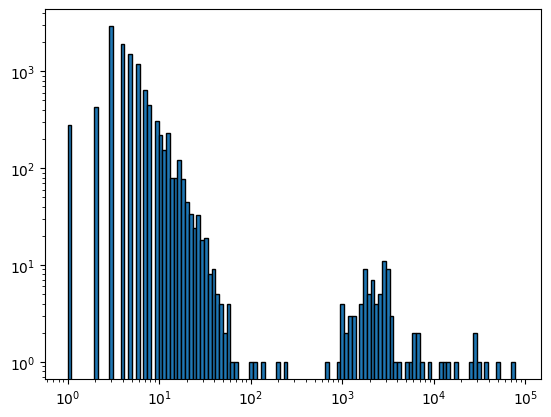

In [5]:

communities = set(partition.values())
user_by_community = { com : 0 for com in communities}
for com in tqdm(partition.values()):
    user_by_community[com] += 1

#only keep communities with more than  5 users
communities = [com for com, val in user_by_community.items()]
print(len(communities))
plt.hist(user_by_community.values(),bins = [1.1**i for i in range(120)], edgecolor= 'black', log = True)
plt.xscale('log')
plt.show()

In [6]:
#aggregate how much points has been placed by each user
class all_in_one:
    def __init__(self, val) -> None:
        self.val = val
    
    def __getitem__(self, index):
        return self.val
    
    def __setitem__(self, index, val):
        self.val = val

def up_community_pixels(communities_pixels, row, is_mod):
    if not is_mod:
        communities_pixels[partition.get(row.user, -1)] = communities_pixels.get(partition.get(row.user,-2), 0) + 1 
    return communities_pixels

communities_pixels = []

visualise_at_interval(
    up_community_pixels, 
    {}, 
    -1, 
    all_in_one(all_in_one({})),
    "",
    rez = communities_pixels,
)

communities_pixels = communities_pixels[1][0][0]
for community in communities_pixels:
    if community != -1:
        communities_pixels[-1] += communities_pixels[community]
for community in communities_pixels:
    if community != -1:
        communities_pixels[-1] += communities_pixels[community]
total_pixels = communities_pixels.pop(-1)

loaded file : 2023_place_canvas_history-000000000019.csv.gzip

start making visualizations


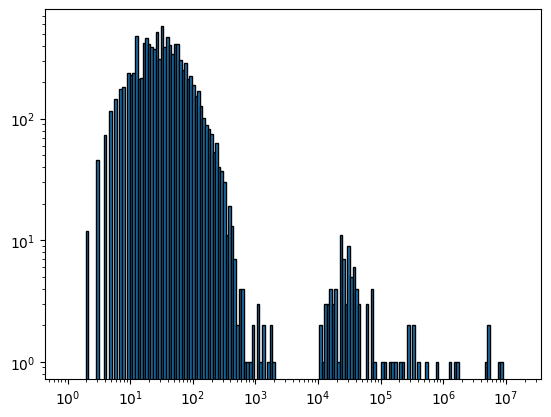

In [7]:
plt.hist(communities_pixels.values(), bins = [1.1**i for i in range(175)], edgecolor= 'black', log= True)
plt.xscale('log')
plt.show()

#sort communities by number of pixels placed
community_pixels = sorted(communities_pixels.items(), key=lambda item: item[1], reverse=True)

In [8]:

communities_selected = [community for community, activity in community_pixels if activity > 100_000]
len(communities_selected)

22

In [11]:
saturation = 0.8
lightness = 0.8

hues = np.linspace(0, 1, len(communities_selected), endpoint=False)

# Create colors for both groups
colors = {community	: hsv_to_rgb([hue, saturation, lightness]) for community, hue in zip(communities_selected,hues)}

red = np.array([255,0,0], dtype = np.uint8)
white = np.array([0,0,0], dtype = np.uint8)
def aggregate(rez, row, is_mod) : 
    if not is_mod :
        user_community = partition.get(row.user,-1)
        if user_community in communities_selected :
            rez[user_community] += 1
        rez[-1] += 1
    return rez

colors[-1] = np.array([255,255,255], dtype = np.uint8)

def transform(image, community):
    converted_img = convertImage(image, lambda dict : colors[community] * dict[community] / max(dict[-1],1), dtype = np.float64)
    converted_img /= np.max(converted_img)
    converted_img *= 255
    return converted_img.astype(np.uint8)

rez = []
visualise_at_interval( 
    aggregate ,
    {community : partial(transform, community = community) for community in communities_selected}, 
    -1, 
    [[{ community : 0 for community in colors} for i in range(2000)] for j in range(1000)],
    lambda community : f"friends/last_pixel_by_community/{community}",
    rez = rez,
)

loaded file : 2023_place_canvas_history-000000000001.csv.gzip

just made summary until 0 days 04:00:00


100%|██████████| 546651/546651 [00:01<00:00, 300218.32it/s]


: 

: 

In [56]:
images = rez
communities_detected = []

def best_commmunity_color(dict):
    community = max(dict, key=lambda x : -1 if x == -1 else dict[x])
    communities_detected.append(tuple(colors[community].tolist()))
    return colors[community] * dict[community] / max(dict[-1],1)


converted_imgs = [convertImage(image, best_commmunity_color, dtype=np.float64)  for image in images]
print(np.max(converted_img))  
converted_img /= np.max(converted_img)
converted_img *= 255
print(converted_img)
imwrite("visualisation/friends/summary.png",converted_img.astype(np.uint8))

0.8000000000000002
[[[ 34.45456697  21.92563352   6.89091339]
  [ 31.32352941  19.93315508   6.26470588]
  [ 27.14828897   5.42965779   5.42965779]
  ...
  [ 79.80916031  15.96183206  15.96183206]
  [ 71.95544554  14.39108911  14.39108911]
  [ 52.72074659  10.54414932  10.54414932]]

 [[ 25.21978022   5.04395604   5.04395604]
  [ 10.91701903   8.00581395  40.02906977]
  [  8.99294671   6.59482759  32.97413793]
  ...
  [ 91.3255814   18.26511628  18.26511628]
  [ 76.80722892  15.36144578  15.36144578]
  [ 73.06314797  14.61262959  14.61262959]]

 [[ 35.64516129   7.12903226   7.12903226]
  [ 33.55263158  28.6722488    6.71052632]
  [  8.21403006   6.02362205  30.11811024]
  ...
  [ 88.14814815  17.62962963  17.62962963]
  [ 81.74641148  16.3492823   16.3492823 ]
  [ 80.86956522  16.17391304  16.17391304]]

 ...

 [[103.2496937  111.34770889  22.26954178]
  [108.87115762 117.41007194  23.48201439]
  [ 94.28250863 101.67721519  20.33544304]
  ...
  [ 70.0993564   75.59734513  15.11946903]

In [45]:
from collections import Counter

communities_detected = [tuple(community) for community in communities_detected]
# Use Counter to count occurrences
count_dict = Counter(communities_detected)

print(count_dict)

Counter({(0.8, 0.15999999999999998, 0.15999999999999998): 606184, (0.8, 0.19840000000000002, 0.15999999999999998): 7158, (0.8, 0.23679999999999995, 0.15999999999999998): 6786, (0.8, 0.3520000000000001, 0.15999999999999998): 6308, (0.8, 0.2751999999999999, 0.15999999999999998): 6240, (0.8, 0.31359999999999993, 0.15999999999999998): 6215, (0.8, 0.3904, 0.15999999999999998): 5993, (0.8, 0.42880000000000007, 0.15999999999999998): 5860, (0.8, 0.4672, 0.15999999999999998): 5810, (0.8, 0.544, 0.15999999999999998): 5638, (0.8, 0.5056, 0.15999999999999998): 5637, (0.8, 0.5824, 0.15999999999999998): 5554, (0.8, 0.736, 0.15999999999999998): 5411, (0.7488, 0.8, 0.15999999999999998): 5392, (0.8, 0.6208, 0.15999999999999998): 5332, (0.8, 0.6592000000000001, 0.15999999999999998): 5322, (0.8, 0.7744, 0.15999999999999998): 5307, (0.7872, 0.8, 0.15999999999999998): 5283, (0.8, 0.6976000000000001, 0.15999999999999998): 5269, (0.6336, 0.8, 0.15999999999999998): 5136, (0.7103999999999999, 0.8, 0.1599999999

# Todo

In [42]:
rez = []

interval = 5

visualise_at_interval(
    get_color, 
    {}, 
    -1, 
    all_in_one(all_in_one({})),
    "",
    EndingTimeStamp= pd.Timedelta(hours = 1),
    rez = rez,
)
colors_each_min = [image[0][0] for image in rez]
colors_each_min = colors_each_min[1:]
#sum up pixels
for i in range(0,len(colors_each_min)):
    colors_each_min[i]['total'] = 0
    for color in colors_each_min[i]:
        if color != 'total':
            colors_each_min[i]['total'] += colors_each_min[i].get(color,0)

print([image['total'] for image in colors_each_min])

#normalize numbers of pixels
'''
for i in range(0,len(colors_each_min)):
    for color in colors_each_min[i]:
        if color != 'total':
            colors_each_min[i][color] = colors_each_min[i][color] / colors_each_min[i]['total']
'''

#smooth points if necesary
smoothed_colors_each_min = []
smooth_factor = 2
for i in range(0,len(colors_each_min)-smooth_factor):
    smoothed_colors_each_min.append({})
    for color in colors_each_min[i]:
        smoothed_colors_each_min[i][color] = np.sum(
            [colors_each_min[i+j][color] for j in range(0,smooth_factor)]) / smooth_factor

#plot curve of pixels placement frequency with colors as area under the curve
import matplotlib.pyplot as plt

colors = set()
for i in range(0,len(smoothed_colors_each_min)):
    for color in colors_each_min[i]:
        if color != 'total':
            colors.add(color)

#sort colors by frequency
colors = sorted(colors, key=lambda color: smoothed_colors_each_min[-1][color])

plt.figure()
curr_y = [0 for i in range(0,len(smoothed_colors_each_min))]

for color in colors:
    if color == 'total':
        continue
    x = range(0,len(smoothed_colors_each_min))
    loc_y = [smoothed_colors_each_min[i].get(color,0) for i in range(0,len(smoothed_colors_each_min))]
    last_y = copy.deepcopy(curr_y)
    curr_y = [curr_y[i] + loc_y[i] for i in range(0,len(smoothed_colors_each_min))]
    p_color = color
    if color == '#FFFFFF': #white
        p_color = 'lightgrey'
    plt.plot(x, curr_y, color=p_color, label=color)
    plt.fill_between(x, last_y, curr_y, alpha=0.5, color=p_color)

#plot tick every x hours instead of minutes
hours_tick = 5
ticks = [i for i in range(0,len(smoothed_colors_each_min),hours_tick*60//interval)]
plt.xticks(ticks, [str(int(i*interval/60)) for i in ticks])

plt.xlabel('Temps en heures')
plt.ylabel('Nombre de pixels placés sur les 5 dernières minutes')
plt.savefig('pixel_placement_frequency_by_color.png', dpi=1000)
plt.show()


loaded file : 2023_place_canvas_history-000000000000.csv.gzip

start making visualizations


[{},
 {'#FFFFFF': 30821,
  '#FF4500': 110951,
  '#B44AC0': 30705,
  '#3690EA': 78922,
  '#00A368': 32807,
  '#000000': 166817,
  '#FFD635': 84722,
  '#FFA800': 17123}]

# Users activity distribution

In [ ]:
#aggregate how much points has been placed by each user
users_pixels = {}

def up_user_pixels(aggr, row, is_mod):
    if not is_mod:
        users_pixels[row.user] = users_pixels.get(row.user, 0) + 1 
    return users_pixels

interval = 3000
max_pixels = (interval / 5) + 1

visualise_at_interval(
    up_user_pixels, 
    {}, 
    -1, 
    all_in_one(all_in_one({})),
    "",
    EndingTimeStamp= pd.Timedelta(minutes = interval),
)

#sort users by number of pixels placed
users_pixels = sorted(users_pixels.items(), key=lambda item: item[1], reverse=True)
#remove cheaters
users_pixels = [user for user in users_pixels if user[1] < max_pixels]

#plot curve of pixels placement frequency by users
import matplotlib.pyplot as plt

plt.figure()
x = range(0,len(users_pixels))
y = [user[1] for user in users_pixels]
plt.plot(x, y, color='blue')
plt.xlabel('Utilisateurs')
plt.ylabel('Nombre de pixels')
plt.savefig('pixel_placement_frequency_by_user.png', dpi=1000)

In [ ]:
stats = {'pixels': 0, 'mods': 0, 'non_mods': 0}
users = set()
def aggregate(stats, users, user, is_mod):
    users.add(user)
    stats['pixels'] += 1
    if is_mod:
        stats['mods'] += 1
    else:
        stats['non_mods'] += 1

visualise_at_interval(
    lambda x, y, user, is_mod : aggregate(stats, users, user, is_mod),
    {}, 
    pd.Timedelta(minutes= 30), 
    [["#FFFFFF" for i in range(2000)] for i in range(1000)],
    "image",
    duration= pd.Timedelta(minutes= 1)
) 
stats, users


matActivité forme : [x][y] = freq de maj --> image de l'activité bleu à rouge

### map:
- map de zone d'activité
- map de zone d'activité par couleur?
- map de certains utilisateurs actif 
- map de la couleur la plus utilisé
- map de la variété d'utilisateurs
- 

### statistique descriptive:
- activité par utilisateur
- activité par couleur
- activité par heure

### identifications:
- identifié les bots
- identifié communauté / projet de communauté
- identification de la modération

### technique:
- download fait
- augmentation taille grille fait
- detection des antagonistes pour trouver les communautés fait
- prétraitemtent des temps et diverse valeur pour réduire le temps d'ouverture fait